In [ ]:
!pip install torchmetrics[image]
!pip install gdown
!pip install ema-pytorch

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms.v2 as transforms
import torchvision.transforms.v2.functional as T
from torch.utils.data import DataLoader
# from torchmetrics.image.fid import FrechetInceptionDistance
# from torchmetrics.image.inception import InceptionScore
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.parametrizations import spectral_norm as SpectralNorm
# from torch.nn.utils import spectral_norm as SpectralNorm
device = "cuda" if torch.cuda.is_available() else "cpu"
# torch.backends.cudnn.benchmarks = True

import random
import numpy as np
import os
import torchvision
from torchvision.utils import save_image
from scipy.stats import truncnorm

import torchinfo
import os, shutil
import zipfile
# import gdown
import matplotlib.pyplot as plt
import math

# from ema_pytorch import EMA

In [4]:
class GANOptions:
    def __init__(self, image_size=64, latent_dim=128, batch_size=32, n_epochs=10, data_path="", output_path="") -> None:
        self.num_epochs = n_epochs
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.label_softness = 0.1
        self.num_classes = 20

        self.data_path = data_path
        self.image_size = image_size
        self.img_ch = 3

        self.output_path = output_path
        self.save_interval = 100
        self.fid_interval = 100
        self.save_checkpoint = True
        self.load_checkpoint = False

        self.generator_frequency = 1
        self.generator_bn = True
        self.generator_lr = 2e-4
        self.generator_beta1 = 0.5
        self.generator_beta2 = 0.999
        self.weight_decay = 2.5e-5

        self.discriminator_frequency = 1
        self.discriminator_bn = True
        self.discriminator_lr = 2e-4
        self.discriminator_beta1 = 0.5
        self.discriminator_beta2 = 0.999
        self.discriminator_kernel = 5
        

In [5]:
class Blur(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        kernel = [
            [1,2,1],
            [2,4,2],
            [1,2,1]
        ]
        kernel = torch.tensor([[kernel]], dtype=torch.float)
        kernel /= kernel.sum()
        self.kernel = nn.Parameter(kernel, requires_grad=False)
        self.pad = nn.ReplicationPad2d(1)
    
    def forward(self, x):
        b,c,h,w = x.shape
        x = x.view(-1, 1, h, w)
        x = self.pad(x)
        x = F.conv2d(x, self.kernel)
        return x.view(b,c,h,w)

class Upsample(nn.Module):
    def __init__(self, scale_factor=2):
        super().__init__()
        self.scale_factor = scale_factor
        self.upsample = nn.Upsample(scale_factor=self.scale_factor, mode="bilinear", align_corners=False)
        self.blur = Blur()
    
    def forward(self, x):
        return self.blur(self.upsample(x))

class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features, affine=False, eps=1e-04)
        self.embedding = SpectralNorm(nn.Embedding(num_classes, num_features * 2))

        self.embedding.weight.data[:, :num_features].fill_(1.)
        self.embedding.weight.data[:, num_features:].zero_()

    def forward(self, x, y):
        out = self.bn(x)
        shape = y.shape
        if len(shape) == 1:
            embed = self.embedding(y)
        else:
            y = y.type(self.embedding.weight.data.dtype)
            embed = y.matmul(self.embedding.weight.data)

        gain, bias = embed.chunk(2, 1)
        gain = gain.view(-1, self.num_features, 1, 1)
        bias = bias.view(-1, self.num_features, 1, 1)
        out = gain * out + bias
        return out


def sp_conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, epsilon=1e-04):
    return SpectralNorm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding), eps=epsilon)


class NonLocalBlock(nn.Module):
    def __init__(self, in_channels):
        super(NonLocalBlock, self).__init__()

        self.channels = in_channels

        self.theta = SpectralNorm(nn.Conv2d(in_channels, in_channels // 8, kernel_size=1, stride=1, padding=0, bias=False))

        self.phi = SpectralNorm(nn.Conv2d(in_channels, in_channels // 8, kernel_size=1, stride=1, padding=0, bias=False))

        self.g = SpectralNorm(nn.Conv2d(in_channels, in_channels // 2, kernel_size=1, stride=1, padding=0, bias=False))

        self.o = SpectralNorm(nn.Conv2d(in_channels // 2, in_channels, kernel_size=1, stride=1, padding=0, bias=False))

        self.gamma = nn.Parameter(torch.tensor(0.), requires_grad=True)
        
    def forward(self, x, *args):
        img_size = x.shape[2] * x.shape[3]
        
        theta = self.theta(x)
        phi = F.max_pool2d(self.phi(x), kernel_size=2)
        g = F.max_pool2d(self.g(x), kernel_size=2)

        theta = theta.view(-1, self.channels // 8, img_size)
        phi = phi.view(-1, self.channels // 8, img_size // 4)
        g = g.view(-1, self.channels // 2, img_size // 4)

        beta = F.softmax(torch.bmm(theta.permute(0, 2, 1), phi), dim=-1)

        o = self.o(torch.bmm(g, beta.permute(0, 2, 1))
                   .view(-1, self.channels // 2, x.shape[2], x.shape[3]))

        z = self.gamma * o + x

        return z
    

class Gblock(nn.Module):
    def __init__(self, in_channels, out_channels,
                 conv=sp_conv2d, batch_norm=nn.BatchNorm2d,
                 num_classes=10, channel_ratio=4,
                 upsample=None
                 ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_channels = out_channels // channel_ratio
        self.num_classes = num_classes

        self.conv1 = conv(self.in_channels, self.hidden_channels, kernel_size=1, padding=0)
        self.conv2 = conv(self.hidden_channels, self.hidden_channels)
        self.conv3 = conv(self.hidden_channels, self.hidden_channels)
        self.conv4 = conv(self.hidden_channels, self.out_channels, kernel_size=1, padding=0)

        self.bn1 = batch_norm(self.in_channels)
        self.bn2 = batch_norm(self.hidden_channels)
        self.bn3 = batch_norm(self.hidden_channels)
        self.bn4 = batch_norm(self.hidden_channels)

        self.activation = nn.ReLU(True)
        self.upsample = upsample

    def forward(self, x):
        h = self.conv1(self.activation(self.bn1(x)))

        h = self.activation(self.bn2(h))

        # drop channels
        if self.in_channels != self.out_channels:
            x = x[:, :self.out_channels]

        if self.upsample is not None:
            h = self.upsample(h)
            x = self.upsample(x)

        h = self.conv2(h)

        h = self.conv3(self.activation(self.bn3(h)))

        h = self.conv4(self.activation(self.bn4(h)))

        return x + h
    

class Dblock(nn.Module):
    def __init__(self, in_channels, out_channels,
                 conv=sp_conv2d, channel_ratio=4,
                 downsample=None
                 ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_channels = out_channels // channel_ratio

        self.conv1 = conv(self.in_channels, self.hidden_channels, kernel_size=1, padding=0)
        self.conv2 = conv(self.hidden_channels, self.hidden_channels)
        self.conv3 = conv(self.hidden_channels, self.hidden_channels)
        self.conv4 = conv(self.hidden_channels, self.out_channels, kernel_size=1, padding=0)

        self.activation = nn.ReLU(True)
        self.downsample = downsample

        self.skip = None
        if self.in_channels != self.out_channels:
            self.skip = (
                conv(self.in_channels, self.out_channels - self.in_channels,
                     kernel_size=1, padding=0)
            )

    def shortcut(self, x):
        if self.downsample is not None:
            x = self.downsample(x)

        if self.skip is not None:
            x = torch.cat([x, self.skip(x)], dim=1)

        return x

    def forward(self, x):
        h = self.conv1(self.activation(x))
        h = self.conv2(self.activation(h))
        h = self.conv3(self.activation(h))
        h = self.activation(h)

        if self.downsample is not None:
            h = self.downsample(h)

        h = self.conv4(h)

        return h + self.shortcut(x)


class Generator(nn.Module):
    def __init__(self, z_dim=128, img_size=64, img_ch=3, num_classes=10, ch=32, G_shared=True):
        super().__init__()
        self.img_size=img_size
        self.img_ch = img_ch
        self.num_classes = num_classes
        self.z_dim = z_dim
        self.embedding_dim = 128
        self.ch = ch

        self.architectures = {
            64: {
                "in_channels": [16, 16, 8, 4],
                "out_channels": [16, 8, 4, 2]
            },
            128: {
                "in_channels": [16, 16, 8, 4, 2],
                "out_channels": [16, 8, 4, 2, 1]
            },
            256: {
                "in_channels": [16, 16, 8, 8, 4, 2],
                "out_channels": [16, 8, 8, 4, 2, 1]
            },
            512: {
                "in_channels": [16, 16, 8, 8, 4, 2, 1],
                "out_channels": [16, 8, 8, 4, 2, 1, 1]
                }
        }
        self.architecture = self.architectures[self.img_size]

        self.G_shared = G_shared

        self.embedding = SpectralNorm(nn.Embedding(self.num_classes, self.embedding_dim)) if self.G_shared else nn.Sequential()
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        
        n_classes = self.z_dim + self.embedding_dim if self.G_shared else self.num_classes

#         self.init = nn.Sequential(
#             Upsample(scale_factor=4),
#             sp_conv2d(self.z_dim + self.embedding_dim if self.G_shared else self.z_dim, 
#                       self.architecture["in_channels"][0] * self.ch, 
#                       kernel_size=1, padding=0)
#         )
        
        self.init = nn.Sequential(
            SpectralNorm(torch.nn.ConvTranspose2d(self.z_dim + self.embedding_dim if self.G_shared else self.z_dim, 
                                     self.architecture["in_channels"][0] * self.ch, kernel_size=4, stride=1, padding=0, bias=False)),
            torch.nn.BatchNorm2d(self.architecture["in_channels"][0] * self.ch, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.n_blocks = len(self.architecture["in_channels"])
        self.upsample = nn.Upsample(scale_factor=2)
        upsample = Upsample(scale_factor=2)
        blocks = []
    
        for i in range(4):
            in_channels = self.architecture["in_channels"][i] * self.ch
            out_channels = self.architecture["out_channels"][i] * self.ch
            blocks += [Gblock(in_channels, in_channels, num_classes=n_classes)]
            blocks += [Gblock(in_channels, out_channels, num_classes=n_classes, 
                              upsample=self.upsample)]
        
        non_local_in_channels = self.architecture["out_channels"][3] * self.ch
        blocks += [NonLocalBlock(non_local_in_channels)]

        for i in range(4, self.n_blocks):
            in_channels = self.architecture["in_channels"][i] * self.ch
            out_channels = self.architecture["out_channels"][i] * self.ch
            blocks += [Gblock(in_channels, in_channels, num_classes=n_classes)]
            blocks += [Gblock(in_channels, out_channels, num_classes=n_classes, 
                              upsample=self.upsample)]
        
        final_out_channels = self.architecture["out_channels"][-1] * self.ch
        blocks += [
            nn.BatchNorm2d(final_out_channels),
        ]
        self.blocks = nn.ModuleList(blocks)

        self.output = nn.Sequential(
            nn.ReLU(True),
            sp_conv2d(final_out_channels, self.img_ch),
            nn.Tanh()
        )

    def forward(self, z, y):
        if self.G_shared:
            shape = y.shape
            if len(shape) == 1:
                embed = self.embedding(y)
            else:
                y = y.type(self.embedding.weight.data.dtype)
                embed = y.matmul(self.embedding.weight.data)

            z = torch.cat([embed, z], 1)
            y = z

        z = z.unsqueeze(-1).unsqueeze(-1)

        z = self.init(z)

        for index, block in enumerate(self.blocks):
            z = block(z)

        return self.output(z)
    

class Discriminator(nn.Module):
    def __init__(self, img_size=64, img_ch=3, num_classes=10, ch=32):
        super().__init__()
        self.img_size=img_size
        self.img_ch = img_ch
        self.num_classes = num_classes
        self.embedding_dim = 128
        self.ch = ch

        self.architectures = {
            64: {
                "in_channels": [1, 2, 4, 8],
                "out_channels": [2, 4, 8, 16]
            },
            128: {
                "in_channels": [1, 2, 4, 8, 16],
                "out_channels": [2, 4, 8, 16, 16]
            },
            256: {
                "in_channels": [1, 2, 4, 8, 8, 16],
                "out_channels": [2, 4, 8, 8, 16, 16]
            },
            512: {
                "in_channels": [1, 2, 4, 8, 8, 16, 16],
                "out_channels": [2, 4, 8, 8, 16, 16, 16]
            }
        }
        self.architecture = self.architectures[self.img_size]

        in_channels = self.architecture["in_channels"][0] * self.ch
        self.init = nn.Sequential(
            sp_conv2d(self.img_ch, in_channels)
        )

        self.n_blocks = len(self.architecture["in_channels"])
        self.downsample = nn.AvgPool2d(kernel_size=2, stride=2)
        blocks = []

        for i in range(self.n_blocks - 4):
            in_channels = self.architecture["in_channels"][i] * self.ch
            out_channels = self.architecture["out_channels"][i] * self.ch
            blocks += [Dblock(in_channels, out_channels, downsample=self.downsample)]
            blocks += [Dblock(out_channels, out_channels)]

        non_local_in_channels = self.architecture["in_channels"][self.n_blocks - 4] * self.ch

        blocks += [NonLocalBlock(non_local_in_channels)]

        for i in range(self.n_blocks - 4, self.n_blocks):
            in_channels = self.architecture["in_channels"][i] * self.ch
            out_channels = self.architecture["out_channels"][i] * self.ch
            blocks += [Dblock(in_channels, out_channels, downsample=self.downsample)]
            blocks += [Dblock(out_channels, out_channels)]
        
        self.net = nn.Sequential(*blocks)

        self.relu = nn.ReLU(True)
        final_out_channels = self.architecture["out_channels"][-1] * self.ch
        self.linear = SpectralNorm(nn.Linear(final_out_channels, 1))
        self.embedding = SpectralNorm(nn.Embedding(self.num_classes, self.architecture["out_channels"][-1] * self.ch))
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        
    def forward(self, x, y):
        x = self.init(x)

        x = self.net(x)

        # global sum pooling
        x = torch.sum(self.relu(x), (2,3))

        out = self.linear(x)
        shape = y.shape
        if len(shape) == 1:
            embed = self.embedding(y)
        else:
            y = y.type(self.embedding.weight.data.dtype)
            embed = y.matmul(self.embedding.weight.data)

        proj = torch.sum(embed * x, dim=1, keepdim=True)
        out = out + proj
        return out

In [6]:
z = torch.randn(16, 100).to(device)

y = torch.randint(0, 10, (16, )).to(device)

gen = Generator(100, 64, ch=32).to(device)

fake1  = gen(z, y)
print(fake1.shape)

import torchinfo

torchinfo.summary(gen, input_data=(z, y), col_names = ("input_size", "output_size", "num_params"))

torch.Size([16, 3, 64, 64])


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #
Generator                                               [16, 100]                 [16, 3, 64, 64]           --
├─ParametrizedEmbedding: 1-1                            [16]                      [16, 128]                 --
│    └─ModuleDict: 2-1                                  --                        --                        --
│    │    └─ParametrizationList: 3-1                    --                        [10, 128]                 1,280
├─Sequential: 1-2                                       [16, 228, 1, 1]           [16, 512, 4, 4]           --
│    └─ParametrizedConvTranspose2d: 2-2                 [16, 228, 1, 1]           [16, 512, 4, 4]           --
│    │    └─ModuleDict: 3-2                             --                        --                        1,867,776
│    └─BatchNorm2d: 2-3                                 [16, 512, 4, 4]           [16, 512, 4, 4]

In [7]:
disc = Discriminator(64, ch=32).to(device)

fake_pred = disc(fake1, y)
print(fake_pred.shape)


torchinfo.summary(disc, input_data=(fake1, y), col_names = ("input_size", "output_size", "num_params"))

torch.Size([16, 1])


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #
Discriminator                                           [16, 3, 64, 64]           [16, 1]                   --
├─Sequential: 1-1                                       [16, 3, 64, 64]           [16, 32, 64, 64]          --
│    └─ParametrizedConv2d: 2-1                          [16, 3, 64, 64]           [16, 32, 64, 64]          32
│    │    └─ModuleDict: 3-1                             --                        --                        864
├─Sequential: 1-2                                       [16, 32, 64, 64]          [16, 512, 4, 4]           --
│    └─NonLocalBlock: 2-2                               [16, 32, 64, 64]          [16, 32, 64, 64]          1
│    │    └─ParametrizedConv2d: 3-2                     [16, 32, 64, 64]          [16, 4, 64, 64]           128
│    │    └─ParametrizedConv2d: 3-3                     [16, 32, 64, 64]          [16, 4, 64, 64]         

In [5]:
def d_logistic_loss(real_pred, fake_pred):
    real_loss = F.softplus(-real_pred).mean()
    fake_loss = F.softplus(fake_pred).mean()
    return real_loss + fake_loss

def g_nonsaturation_loss(fake_pred):
    loss = F.softplus(-fake_pred).mean()
    return loss

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

def set_requires_grad(model, bool):
    for p in model.parameters():
        p.requires_grad = bool

def gan_weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.orthogonal_(m.weight.data)
#     elif classname.find('BatchNorm') != -1:
#         nn.init.constant_(m.weight.data, 1.0)
#         nn.init.constant_(m.bias.data, 0.0)

def interpolate(batch):
    return F.interpolate(batch, (299, 299), mode="bilinear")


# clear folder
def clear_folder(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))


# make archieve
def make_zip(
        output_filename = "/kaggle/working/images28",
        dir_name = "/kaggle/working/images"
):
    shutil.make_archive(output_filename, 'zip', dir_name)

def unzip_file(
        file="/kaggle/working/game_scenes.zip",
        path_to_unzip="/kaggle/working/"
):
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall(path_to_unzip)
    zip_ref.close()

# download from gdrive
def download_from_drive(
    url = "https://drive.google.com/us?id=17Z7_Fli_vgYuxO8JUoZICCiihG0sXYEY",
    output = "game_scenes.zip"
):
    # 2d_game_scenes.zip
    # https://drive.google.com/file/d/17Z7_Fli_vgYuxO8JUoZICCiihG0sXYEY/view?usp=drive_link

    gdown.download(url, output, quiet=False, fuzzy=True)


def remove(path):
    os.remove(path)


# utils
def plot_to_tensorboard(
    writer, loss_critic, loss_gen, fid, real, fake, tensorboard_step
):
    writer.add_scalar("Loss Critic", loss_critic, global_step=tensorboard_step)
    writer.add_scalar("Loss Generator", loss_gen, global_step=tensorboard_step)
    writer.add_scalar("FID", fid, global_step=tensorboard_step)

    with torch.no_grad():
        # take out (up to) 8 examples to plot
        img_grid_real = torchvision.utils.make_grid(real[:8], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:8], normalize=True)
        writer.add_image("Real", img_grid_real, global_step=tensorboard_step)
        writer.add_image("Fake", img_grid_fake, global_step=tensorboard_step)

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
#     print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def generate_examples(gen, z_dim, labels, truncation=0.7, n=100):
    """
    Tried using truncation trick here but not sure it actually helped anything, you can
    remove it if you like and just sample from torch.randn
    """
    gen.eval()
    for i in range(n):
        with torch.no_grad():
            noise = torch.tensor(truncnorm.rvs(-truncation, truncation, size=(1, z_dim, 1, 1)), device=device, dtype=torch.float32)
            img = gen(noise)
            save_image(img*0.5+0.5, f"saved_examples/img_{i}.png")
    gen.train()

In [16]:
url_abstract = "https://drive.google.com/file/d/1o7tUq4-1dk_QRTJ27NGXoHElf3r1eCbc/view?usp=drive_link"

download_from_drive(
    url="https://drive.google.com/file/d/1CwsRl-Sy5VsMrOaevRNv2dWE4CYwKGmF/view?usp=sharing",
   output="anime.zip")

unzip_file("/kaggle/working/anime.zip")

Downloading...
From (original): https://drive.google.com/uc?id=13JeWY5GMdjayx50SVyZ7ZvcmkPKzxG4K
From (redirected): https://drive.google.com/uc?id=13JeWY5GMdjayx50SVyZ7ZvcmkPKzxG4K&confirm=t&uuid=54c44f3c-f308-41e8-bec8-420897494ea0
To: /kaggle/working/anime.zip
100%|██████████| 602M/602M [00:07<00:00, 82.4MB/s] 


In [6]:
def DiffAugment(x, policy='', channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2).contiguous()
    return x


def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

policy = 'color,translation,cutout'

In [18]:
def gan_weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# remove("/kaggle/working/kth.zip")

In [7]:
seed_everything(1000)

In [8]:
steps = []
fids_steps = []
d_losses = []
g_losses = []
fids = []

def clear_lists():
    steps.clear()
    fids_steps.clear()
    d_losses.clear()
    g_losses.clear()
    fids.clear()

In [9]:
def ortho(model, strength=1e-4, blacklist=[]):
    with torch.no_grad():
        
        for param in model.parameters():
            
        # Only apply this to parameters with at least 2 axes, and not in the blacklist
            if len(param.shape) < 2 or any([param is item for item in blacklist]):
                continue
            if param.grad is None:
                continue
            w = param.view(param.shape[0], -1)
            grad = (2 * torch.mm(torch.mm(w, w.t()) 
              * (1. - torch.eye(w.shape[0], device=w.device)), w))
            
            param.grad.data += strength * grad.view(param.shape)
            
def orthogonal_regularization(model, beta=0.0001, blacklist=[]):
    ortho_loss = 0.0
    for name, param in model.named_parameters():
        if 'weight' in name:
            if any([param is item for item in blacklist]):
                continue
            
            if len(param.shape) > 1:  # Ignoring biases and other 1D parameters
                w = param.view(param.shape[0], -1)
                sym = torch.mm(w, w.t())
                sym = sym * (1.0 - torch.eye(w.shape[0]).to(param.device))
                ortho_loss += beta * sym.norm()
    return ortho_loss

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir, image_transform=None):
        self.root_dir = root_dir

        self.dataset = ImageFolder(root_dir,
                               transform=image_transform)
        self.classes = []
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]
        
        ch, h, w = image.shape

        return image[0],text[0]

In [10]:
class BigGAN:
    def __init__(self, options: GANOptions) -> None:
        self.G = Generator(options.latent_dim, options.image_size,
                           num_classes=options.num_classes, ch=64).to(device)

        self.D = Discriminator(options.image_size,
                               num_classes=options.num_classes, ch=64).to(device)

        self.options = options

    def get_dataloaders(self):
        IMG_SIZE = self.options.image_size
        
#         data_transform = transforms.Compose(
#             [
# #                 transforms.Resize((int(IMG_SIZE*2.5), int(IMG_SIZE*2.5))),
#                 transforms.Resize(IMG_SIZE),
#                 transforms.CenterCrop(IMG_SIZE),
#                 transforms.RandomHorizontalFlip(),
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
#             ]
#         )

        data_transform = transforms.Compose(
            [
                transforms.Resize((IMG_SIZE, IMG_SIZE)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
            ]
        )

        dataset = ImageFolder(root=self.options.data_path, transform=data_transform)
        loader = DataLoader(
            dataset,
            batch_size=self.options.batch_size,
            drop_last=True,
            shuffle=True
        )
#         test_dataset = torch.utils.data.Subset(dataset, torch.arange(3000))
        test_dataset = ImageFolder(root=self.options.data_path1, transform=data_transform)


        test_dataloader = DataLoader(
            test_dataset,
            batch_size=self.options.batch_size,
            shuffle=True,
            drop_last=True
        )

        train_num_classes = len(dataset.classes)

        return [loader, iter(cycle(test_dataloader))], []
    
    def get_optimizers(self):
        opt_gen = optim.Adam(self.G.parameters(), 
                             lr=self.options.generator_lr, 
                             betas=(self.options.generator_beta1, self.options.generator_beta2), 
                             weight_decay=self.options.weight_decay)
        
        opt_disc = optim.Adam(self.D.parameters(), 
                              lr=self.options.discriminator_lr, 
                              betas=(self.options.discriminator_beta1, self.options.discriminator_beta2), 
                              weight_decay=self.options.weight_decay)
        
        return [opt_gen, opt_disc]

    def save(self, path, name=""):
        torch.save(self.G.state_dict(), f"{path}/generator{name}.model")
        torch.save(self.D.state_dict(), f"{path}/discriminator{name}.model")

    def load(self, path, name=""):
        self.G.load_state_dict(torch.load(f"{path}/generator{name}.model"))
        self.D.load_state_dict(torch.load(f"{path}/discriminator{name}.model"))

        self.G.eval()
        self.D.eval()

    def save_checkpoint(self):
        ...

    def load_checkpoint(self):
        ...

    def train(self):
        step=0
        os.makedirs('%s/images' % self.options.output_path, exist_ok=True)
        os.makedirs('%s/samples' % self.options.output_path, exist_ok=True)
        os.makedirs('%s/models' % self.options.output_path, exist_ok=True)

        [train_dataloader, dataiter],[] = self.get_dataloaders()

        self.save_interval = len(train_dataloader) // 1
        
        self.fid_interval = len(train_dataloader) // 4

        self.opt_gen, self.opt_disc = self.get_optimizers()
        
        if not self.weights_init:

            load_checkpoint(self.options.output_path + "/models/" + "gen.model.tar", self.G, self.opt_gen, self.options.generator_lr)
            load_checkpoint(self.options.output_path + "/models/" + "disc.model.tar", self.D, self.opt_disc, self.options.discriminator_lr)

        scaler = torch.cuda.amp.GradScaler()

        fixed_noise = torch.randn(1, self.options.latent_dim).to(device)
        fixed_labels = torch.tensor([3], dtype=torch.long).to(device)

        fid = FrechetInceptionDistance(feature=192, normalize=True).to(device)
        
        fid_value = torch.zeros(1).to(device)
        

        IS = InceptionScore(normalize=True).to(device)
        is_value = torch.zeros(1).to(device)
        max_value_is = torch.tensor(0).to(device)
        
        update_progress_bar = 10
        lazy_interval = 2

        if self.weights_init:
            
            gain = 2 ** 0.5
            xavier = True
            ortho_init = False
        
            for module in self.G.modules():
                if xavier:
                
                    if (isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear)):
                        nn.init.xavier_uniform_(module.weight, gain)
                        if module.bias is not None:
                            nn.init.constant_(module.bias, 0)
                elif ortho_init:
                    if (isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear)):
                        nn.init.orthogonal_(module.weight, gain)
                        if module.bias is not None:
                            nn.init.constant_(module.bias, 0)
                else:
                    if (isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear)):
                        nn.init.normal_(module.weight, 0.0, 0.02)
                        if module.bias is not None:
                            nn.init.constant_(module.bias, 0)
                    if (isinstance(module, nn.BatchNorm2d)):
                        nn.init.normal_(module.weight, 1.0, 0.02)
                        if module.bias is not None:
                            nn.init.constant_(module.bias, 0)
            
            for module in self.D.modules():
                
                if xavier:
                
                    if (isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear)):
                        nn.init.xavier_uniform_(module.weight, gain)
                        if module.bias is not None:
                            nn.init.constant_(module.bias, 0)
                            
                elif ortho_init:
                    if (isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear)):
                        nn.init.orthogonal_(module.weight, gain)
                        if module.bias is not None:
                            nn.init.constant_(module.bias, 0)
                else:
                    if (isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear)):
                        nn.init.normal_(module.weight, 0.0, 0.02)
                        if module.bias is not None:
                            nn.init.constant_(module.bias, 0)
                    if (isinstance(module, nn.BatchNorm2d)):
                        nn.init.normal_(module.weight, 1.0, 0.02)
                        if module.bias is not None:
                            nn.init.constant_(module.bias, 0)

        writer = SummaryWriter(self.options.output_path+"/logs")
        
        ema = EMA(
            self.G,
            beta = 0.9999,              # exponential moving average factor
            update_after_step = 100,    # only after this number of .update() calls will it start updating
            update_every = 10,          # how often to actually update, to save on compute (updates every 10th .update() call)
        )
        
        def reset_grad():
            self.opt_disc.zero_grad()
            self.opt_gen.zero_grad()

        for epoch in range(self.options.num_epochs):
            loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False)
            real: torch.Tensor
            for batch_idx, (real, labels) in loop:
                self.D.train()
                self.G.train()
                
#                 opt_disc.zero_grad()
                with torch.cuda.amp.autocast():
                    real = real.to(device)
                    labels = labels.to(device)

                    real_output = self.D(DiffAugment(real, policy), labels)
                    
                    real_loss = torch.mean(F.relu(1 - real_output))

                    ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
                    noise = torch.randn(self.options.batch_size, self.options.latent_dim).to(device)
                    fake = self.G(noise,labels)

                    fake_pred = self.D(DiffAugment(fake, policy),labels)
                    
                    fake_loss = torch.mean(F.relu(1 + fake_pred))
                    
                    lossD = real_loss + fake_loss
                    
                    ortho_lossD = orthogonal_regularization(self.D, blacklist=[param for param in self.D.embedding.parameters()])

                    lossD = lossD + ortho_lossD

                    d_losses.append(lossD.item())
                
                reset_grad()
                scaler.scale(lossD).backward()
                
                scaler.step(self.opt_disc)
                scaler.update()

#                 opt_gen.zero_grad()
                with torch.cuda.amp.autocast():
                    noise = torch.randn(self.options.batch_size, self.options.latent_dim).to(device)
                    fake = self.G(noise, labels)

                    output = self.D(DiffAugment(fake, policy), labels)
                    
                    gen_loss = - torch.mean(output)
                    
                    ortho_lossG = orthogonal_regularization(self.G, blacklist=[param for param in self.G.embedding.parameters()])

                    gen_loss = gen_loss + ortho_lossG 

                    g_losses.append(gen_loss.item())
                    
                reset_grad()
                scaler.scale(gen_loss).backward()
                scaler.step(self.opt_gen)
                scaler.update()


                if (step+1) % self.fid_interval == 0:
                    real, labels = next(dataiter)

                    with torch.no_grad():
                        with torch.cuda.amp.autocast():
                            real = real.to(device)
                            labels = labels.to(device)
                            noise = torch.randn(self.options.batch_size, self.options.latent_dim).to(device)
                            
                            fake = ema(noise, labels)
                            fake1 = fake.detach() * 0.5 + 0.5

    #                         both = torch.cat([fake.detach(), real], dim=0)
                            grid = vutils.make_grid(fake1, nrow=self.options.batch_size//4, normalize=True)
                            vutils.save_image(grid, f"{self.options.output_path}/images/{epoch}-{batch_idx}.jpg")
                            
                            sample = ema(fixed_noise, fixed_labels) * 0.5 + 0.5
                            vutils.save_image(sample, f"{self.options.output_path}/samples/{step}.jpg")
                
                            real = interpolate(real)
                            fake = interpolate(fake)

                            fid.update(real, real=True)
                            fid.update(fake, real=False)
                            fid_value = fid.compute()
                            fids.append(fid_value.item())
                            fids_steps.append(step+1)
                            fid.reset()
                            
                            IS.update(fake)
                            is_value = IS.compute()[0]
                            IS.reset()
                            
                            if is_value > max_value_is and step > 200:
                                max_value_is = is_value
                                
                                self.save(options.output_path + "/models/", name="max_value_is")

#                     with torch.no_grad():
#                         with torch.cuda.amp.autocast():
#                             fixed_fakes = self.G(fixed_noise, fixed_labels)
                    
#                     plot_to_tensorboard(
#                         writer,
#                         lossD.item(),
#                         gen_loss.item(),
#                         fid_value.item(),
#                         real.detach(),
#                         fixed_fakes.detach(),
#                         step
#                     )
                step+=1
                steps.append(step)
                
                ema.update()
                
                # update progress bar
                if batch_idx % update_progress_bar == 0:
                    loop.set_description(f"Epoch [{epoch}/{self.options.num_epochs}]")
                    loop.set_postfix(loss_g = gen_loss.item(), loss_d = lossD.item(), fid = fid_value.item(), IS = is_value.item() )
            
#             self.save(self.options.output_path + "/models/")
            save_checkpoint(self.G, self.opt_gen, self.options.output_path + "/models/" + "gen.model.tar")
            save_checkpoint(self.D, self.opt_disc, self.options.output_path + "/models/" + "disc.model.tar")

In [11]:
clear_lists()
clear_folder("/kaggle/working/images")
clear_folder("/kaggle/working/samples")
clear_folder("/kaggle/working/classes")
# clear_folder("/kaggle/working/logs")
options = GANOptions(
    n_epochs=30,
    data_path="/kaggle/working/train",
    output_path="/kaggle/working/",
    image_size=64,
    batch_size=32,
)
options.latent_dim=128
options.generator_lr = 1e-4
options.generator_beta1 = 0.0
options.generator_beta2 = 0.9
options.discriminator_lr = 4e-4
options.discriminator_beta1 = 0.0
options.discriminator_beta2 = 0.9
options.label_softness = 0.2
options.num_classes = 256
options.data_path1 = "/kaggle/working/test"


biggan = BigGAN(options)
biggan.weights_init = True

# biggan.load(options.output_path + "/models/", name="max_value_is")

biggan.train()

# biggan.save(options.output_path + "/models/")

In [11]:
make_zip(
    output_filename = "/kaggle/working/images1",
    dir_name = "/kaggle/working/images"
)

In [15]:
make_zip(
    output_filename = "/kaggle/working/classes1",
    dir_name = "/kaggle/working/classes"
)

In [14]:
[train_dataloader, dataiter],[] = biggan.get_dataloaders()

fid = FrechetInceptionDistance(feature=192, normalize=True).to(device)

fid_values = []

for i in range(10):

    real, labels = next(dataiter)

    with torch.cuda.amp.autocast():
        real = real.to(device)
        labels = labels.to(device)
        noise = torch.randn(options.batch_size, options.latent_dim).to(device)
        fake = biggan.G(noise, labels)

        real = interpolate(real)
        fake = interpolate(fake)

        fid.update(real, real=True)
        fid.update(fake, real=False)
        fid_value = fid.compute()
        fid_values.append(fid_value.item())
        fid.reset()

fid_values = np.array(fid_values)

print(np.mean(fid_values))

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 224MB/s] 


7.559765625


In [21]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [14]:
# fixed_noise = torch.randn(16, options.latent_dim).to(device)
for j in range(5):
    fixed_noise = torch.randn(16, options.latent_dim).to(device)
    
    for i in range(15):
        
        labels = torch.tensor([i] * 16, dtype=torch.long).to(device)

        fake = biggan.G(fixed_noise, labels)

        fake1 = fake.detach() * 0.5 + 0.5

        grid = vutils.make_grid(fake1, nrow=4, normalize=True)

        vutils.save_image(grid, f"{options.output_path}/classes/class_{j}_{i}.jpg")
    

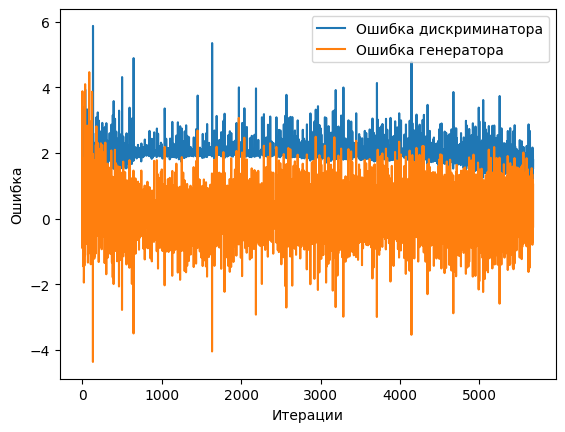

In [13]:

plt.xlabel("Итерации")
plt.ylabel("Ошибка")
plt.plot(steps[:], d_losses[:], label="Ошибка дискриминатора")
plt.plot(steps, g_losses[:], label="Ошибка генератора")
plt.legend()
plt.savefig("/kaggle/working/d_g__losses.png")
plt.show()

In [39]:
print(np.mean(d_losses))
print(np.mean(g_losses))

1.2436860299079664
0.7603827215043769


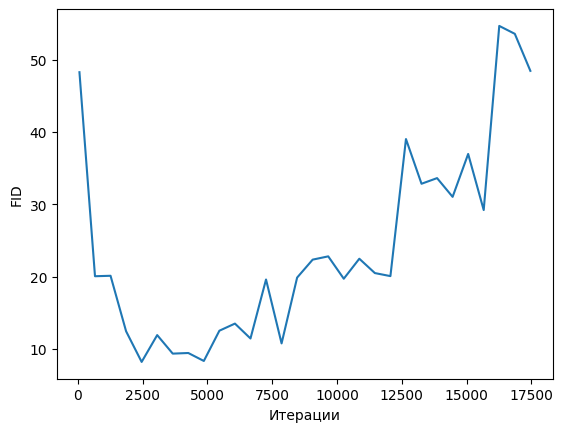

In [27]:
# LOG_FID_INTERVAL+1
# steps_fids = steps[::dcgan.fid_interval]
# print(len(steps_fids))

plt.xlabel("Итерации")
plt.ylabel("FID")
plt.plot(fids_steps[::10], fids[::10])
# plt.legend()
plt.savefig("/kaggle/working/fid.png")
plt.show()